In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle as pkl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
# Load SNLI data
train = pd.read_csv('data/snli_train.tsv', sep='\t')
val = pd.read_csv('data/snli_val.tsv', sep='\t')
train.columns = ['premise', 'hypothesis', 'label']
val.columns = ['premise', 'hypothesis', 'label']

In [3]:
# Change label to numerical
y_train = np.array(train['label'].replace('entailment',1).replace('neutral',0).replace('contradiction',2))
y_val = np.array(val['label'].replace('entailment',1).replace('neutral',0).replace('contradiction',2))

In [4]:
# import spacy
# import string

# tokenizer = spacy.load('en_core_web_sm')
# punctuations = string.punctuation

# def tokenize(sent):
#     tokens = tokenizer(sent)
#     return [token.text.lower() for token in tokens if (token.text not in punctuations)]

# def tokenize_dataset(dataset):
#     token_dataset = []
#     all_tokens = []
#     count = 0
#     for sample in dataset:
#         count += 1
#         tokens = tokenize(sample)
#         token_dataset.append(tokens)
#         all_tokens += tokens
#         if count%200 == 0:
#             print('200 tokenized.')
#     return token_dataset, all_tokens


# train_sentence = pd.concat([train['premise'], train['hypothesis']])
# val_sentence = pd.concat([val['premise'], val['hypothesis']])
# train_tokens, all_tokens = tokenize_dataset(train_sentence)
# pkl.dump(train_tokens, open("train_tokens.p", "wb"))
# pkl.dump(all_tokens, open("all_tokens.p", "wb"))

# val_tokens, all_val_tokens = tokenize_dataset(val_sentence)
# pkl.dump(val_tokens, open("val_tokens.p", "wb"))

In [13]:
# Load tokenized data
train_tokens = pkl.load(open("train_tokens.p", "rb"))
all_tokens = pkl.load(open("all_tokens.p", "rb"))
val_tokens = pkl.load(open("val_tokens.p", "rb"))
dataset = [train_tokens, y_train, val_tokens, y_val]

In [6]:
from collections import Counter
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens, max_vocab_size):
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token
    
def token2index(tokens_data, token2id):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

In [7]:
from torch.utils.data import Dataset
MAX_SENTENCE_LENGTH = 100

class NewsGroupDataset(Dataset):
    def __init__(self, data1, data2, target_list):
        self.data1 = data1
        self.data2 = data2
        self.target_list = target_list
        assert (len(self.data1) == len(self.target_list))

    def __len__(self):
        return len(self.data1)
        
    def __getitem__(self, key):
        token_idx1 = self.data1[key][:MAX_SENTENCE_LENGTH]
        token_idx2 = self.data2[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx1, len(token_idx1), 
                token_idx2, len(token_idx2), label]

def newsgroup_collate_func(batch):
    data1 = []
    len1 = []
    data2 = []
    len2 = []
    label = []
    for datum in batch:
        label.append(datum[4])
        len1.append(datum[1])
        len2.append(datum[3])
    for datum in batch:
        padded1 = np.pad(np.array(datum[0]), 
                         pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                         mode="constant", constant_values=0)
        data1.append(padded1)
        padded2 = np.pad(np.array(datum[2]), 
                         pad_width=((0,MAX_SENTENCE_LENGTH-datum[3])), 
                         mode="constant", constant_values=0)
        data2.append(padded2)
    return [torch.from_numpy(np.array(data1)), torch.LongTensor(len1), 
            torch.from_numpy(np.array(data2)), torch.LongTensor(len2), 
            torch.LongTensor(label)]

In [84]:
class LogisticRegression(nn.Module):
    def __init__(self, vocab_size, emb_dim, approach):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        if approach == 'cat':
            self.linear = nn.Linear(2*emb_dim,3)
        else:
            self.linear = nn.Linear(emb_dim,3)
        self.init_weights()
        self.approach = approach
        
    def forward(self, data1, len1, data2, len2):
        embed1 = self.embed(data1)
        embed1 = torch.sum(embed1, dim=1)
        embed1 /= len1.view(len1.size()[0],1).expand_as(embed1).float()
        
        embed2 = self.embed(data2)
        embed2 = torch.sum(embed2, dim=1)
        embed2 /= len2.view(len2.size()[0],1).expand_as(embed2).float()
        
        if self.approach == 'cat':
            x = torch.cat((embed1,embed2),1)
        elif self.approach == 'product':
            x = torch.mul(embed1,embed2)
        
        output = self.linear(x)
        return output
    
    def init_weights(self):
        nn.init.xavier_normal_(self.linear.weight)
        nn.init.uniform_(self.linear.bias)
        
class NN(nn.Module):
    def __init__(self, vocab_size, emb_dim, approach):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        if approach == 'cat':
            self.hidden1 = nn.Linear(2*emb_dim,20)
        else:
            self.hidden1 = nn.Linear(emb_dim,20)      
        self.hidden2 = nn.Linear(20,10)
        self.output = nn.Linear(10,3) 
        self.dropout = nn.Dropout(p=0.2)
        self.approach = approach
        
    def forward(self, data1, len1, data2, len2):
        
        embed1 = self.dropout(self.embed(data1))
        embed1 = torch.sum(embed1, dim=1)
        embed1 /= len1.view(len1.size()[0],1).expand_as(embed1).float()
        
        embed2 = self.dropout(self.embed(data2))
        embed2 = torch.sum(embed2, dim=1)
        embed2 /= len2.view(len2.size()[0],1).expand_as(embed2).float()
        
        if self.approach == 'cat':
            x = torch.cat((embed1,embed2),1)
        elif self.approach == 'product':
            x = torch.mul(embed1,embed2)
        
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        output = self.output(x)
        return output
    
    
def test_model(loader, model):
    correct = 0
    total = 0
    model.eval()
    for data1, len1, data2, len2, label in loader:
        outputs = F.softmax(model(data1, len1, data2, len2),dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        total += label.size(0)
        correct += predicted.eq(label.view_as(predicted)).sum().item()
    return (100 * correct / total)

In [85]:
def train_model(MODEL, dataset, MAX_VOCAB_SIZE=2000, EMBED_DIM=50, approach='cat', 
                learning_rate=0.01, num_epochs = 10):
    train_tokens, y_train = dataset[0], dataset[1]
    val_tokens, y_val = dataset[2], dataset[3]
    token2id, id2token = build_vocab(all_tokens, MAX_VOCAB_SIZE)
    train_indices = token2index(train_tokens, token2id)
    val_indices = token2index(val_tokens, token2id)
    
    BATCH_SIZE = 32
    train_dataset = NewsGroupDataset(train_indices[:100000], train_indices[100000:], y_train)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

    val_dataset = NewsGroupDataset(val_indices[:1000], val_indices[1000:], y_val)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

    
    model = MODEL(MAX_VOCAB_SIZE+2,EMBED_DIM,approach)
    criterion = torch.nn.CrossEntropyLoss()  
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    val_acc_ls, train_acc_ls = [], []
    
    for epoch in range(num_epochs):
        for i, (data1, len1, data2, len2, label) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            outputs = model(data1, len1, data2, len2)
            loss = criterion(outputs, label)
            loss.backward()
            optimizer.step()
        
        train_acc = test_model(train_loader, model)
        val_acc = test_model(val_loader, model)
        val_acc_ls.append(val_acc)
        train_acc_ls.append(train_acc)
        #print('Epoch: [{}/{}], Train ACC: {}, Val Acc: {}'.format(epoch+1, num_epochs, train_acc, val_acc))

    return model, train_acc_ls, val_acc_ls

#### Tune the way to interact two sentences (concatenation vs element-wise multiplication)

60.2
64.6


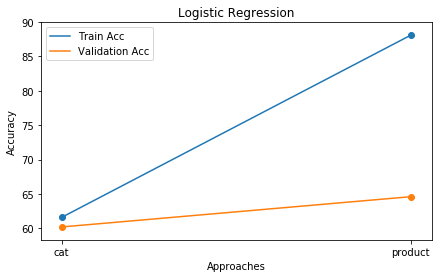

62.8
66.6


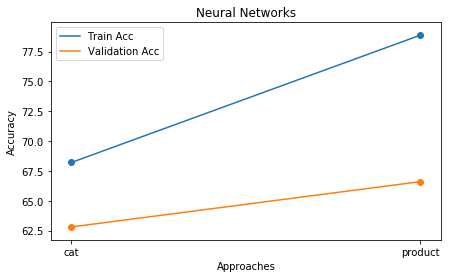

In [14]:
approach_ls = ['cat', 'product']
# Logistic Regression
train_acc, val_acc = [], []
fig = plt.figure(figsize=(7,4))
for i in approach_ls:
    model, train_ls, val_ls = train_model(LogisticRegression, dataset, approach=i)
    train_acc.append(train_ls[-1])
    val_acc.append(val_ls[-1])
    print(val_ls[-1])
plt.plot(approach_ls, train_acc, label='Train Acc')
plt.plot(approach_ls, val_acc, label='Validation Acc')
plt.scatter(approach_ls, train_acc)
plt.scatter(approach_ls, val_acc)
plt.xlabel('Approaches')
plt.ylabel('Accuracy')
plt.title('Logistic Regression')
plt.legend()
plt.show()

# Neural Networks
train_acc, val_acc = [], []
fig = plt.figure(figsize=(7,4))
for i in approach_ls:
    model, train_ls, val_ls = train_model(NN, dataset, approach=i)
    train_acc.append(train_ls[-1])
    val_acc.append(val_ls[-1])
    print(val_ls[-1])
plt.plot(approach_ls, train_acc, label='Train Acc')
plt.plot(approach_ls, val_acc, label='Validation Acc')
plt.scatter(approach_ls, train_acc)
plt.scatter(approach_ls, val_acc)
plt.xlabel('Approaches')
plt.ylabel('Accuracy')
plt.title('Neural Networks')
plt.legend()
plt.show()

#### Tune learning rate

59.9
65.3
66.9
62.3
54.4


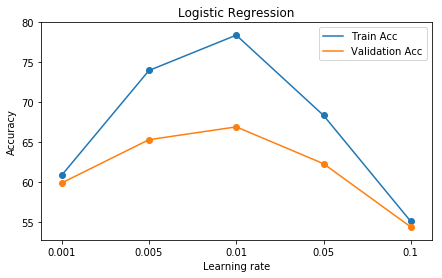

62.2
64.6
63.8
42.2
33.8


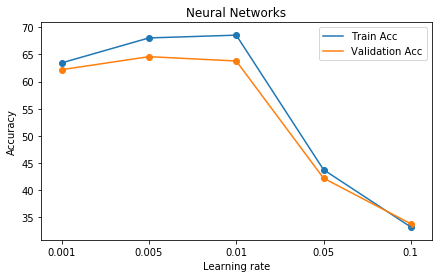

In [16]:
lr_range = [0.001, 0.005, 0.01, 0.05, 0.1]
# Logistic Regression
train_acc, val_acc = [], []
fig = plt.figure(figsize=(7,4))
for lr in lr_range:
    model, train_ls, val_ls = train_model(LogisticRegression, dataset, approach='product', learning_rate=lr)
    train_acc.append(train_ls[-1])
    val_acc.append(val_ls[-1])
    print(val_ls[-1])
plt.plot([1,2,3,4,5], train_acc, label='Train Acc')
plt.plot([1,2,3,4,5], val_acc, label='Validation Acc')
plt.scatter([1,2,3,4,5], train_acc)
plt.scatter([1,2,3,4,5], val_acc)
plt.xticks([1,2,3,4,5], lr_range)
plt.xlabel('Learning rate')
plt.ylabel('Accuracy')
plt.title('Logistic Regression')
plt.legend()
plt.show()

# Neural Networks
train_acc, val_acc = [], []
fig = plt.figure(figsize=(7,4))
for lr in lr_range:
    model, train_ls, val_ls = train_model(NN, dataset, approach='cat', learning_rate=lr)
    train_acc.append(train_ls[-1])
    val_acc.append(val_ls[-1])
    print(val_ls[-1])
plt.plot([1,2,3,4,5], train_acc, label='Train Acc')
plt.plot([1,2,3,4,5], val_acc, label='Validation Acc')
plt.scatter([1,2,3,4,5], train_acc)
plt.scatter([1,2,3,4,5], val_acc)
plt.xticks([1,2,3,4,5], lr_range)
plt.xlabel('Learning rate')
plt.ylabel('Accuracy')
plt.title('Neural Networks')
plt.legend()
plt.show()

#### Tune vocabulary size

65.7
63.9
64.7
63.4


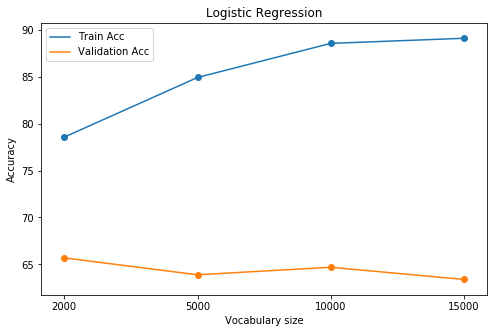

64.5
65.4
65.5
66.1


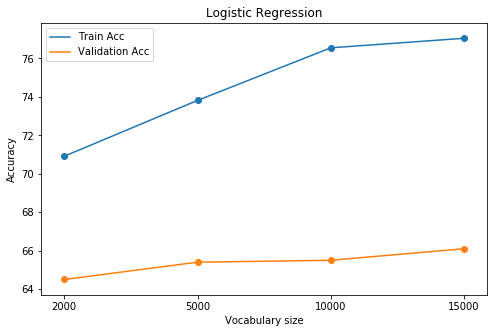

In [17]:
vocab_size_range = [2000, 5000, 10000, 15000]
## Logistic Regression
train_acc, val_acc = [], []
fig = plt.figure(figsize=(8,5))
for vocab_size in vocab_size_range:
    model, train_ls, val_ls = train_model(LogisticRegression, dataset, MAX_VOCAB_SIZE=vocab_size,
                                          approach='product', learning_rate=0.01)
    train_acc.append(train_ls[-1])
    val_acc.append(val_ls[-1])
    print(val_ls[-1])
plt.plot([1,2,3,4], train_acc, label='Train Acc')
plt.plot([1,2,3,4], val_acc, label='Validation Acc')
plt.scatter([1,2,3,4], train_acc)
plt.scatter([1,2,3,4], val_acc)
plt.xticks([1,2,3,4], vocab_size_range)
plt.xlabel('Vocabulary size')
plt.ylabel('Accuracy')
plt.title('Logistic Regression')
plt.legend()
plt.show()


# Neural Networks
train_acc, val_acc = [], []
fig = plt.figure(figsize=(8,5))
for vocab_size in vocab_size_range:
    model, train_ls, val_ls = train_model(NN, dataset, MAX_VOCAB_SIZE=vocab_size,
                                          approach='product', learning_rate=0.005)
    train_acc.append(train_ls[-1])
    val_acc.append(val_ls[-1])
    print(val_ls[-1])
plt.plot([1,2,3,4], train_acc, label='Train Acc')
plt.plot([1,2,3,4], val_acc, label='Validation Acc')
plt.scatter([1,2,3,4], train_acc)
plt.scatter([1,2,3,4], val_acc)
plt.xticks([1,2,3,4], vocab_size_range)
plt.xlabel('Vocabulary size')
plt.ylabel('Accuracy')
plt.title('Neural Networks')
plt.legend()
plt.show()

64.5
65.1
63.5
64.5


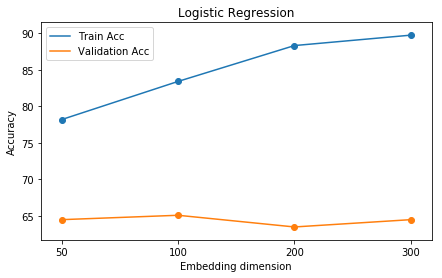

65.0
64.8
65.4
66.0


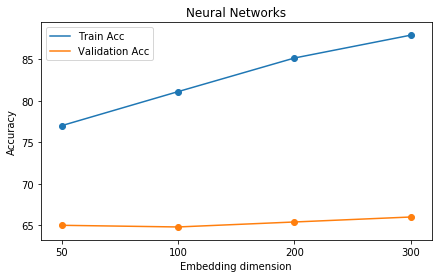

In [23]:
embed_dim_range = [50, 100, 200, 300]
# Logistic Regression
train_acc, val_acc = [], []
fig = plt.figure(figsize=(7,4))
for embed_dim in embed_dim_range:
    model, train_ls, val_ls = train_model(LogisticRegression, dataset, MAX_VOCAB_SIZE=2000,
                                          EMBED_DIM=embed_dim, approach='product', learning_rate=0.01)
    train_acc.append(train_ls[-1])
    val_acc.append(val_ls[-1])
    print(val_ls[-1])
plt.plot([1,2,3,4], train_acc, label='Train Acc')
plt.plot([1,2,3,4], val_acc, label='Validation Acc')
plt.scatter([1,2,3,4], train_acc)
plt.scatter([1,2,3,4], val_acc)
plt.xticks([1,2,3,4], embed_dim_range)
plt.xlabel('Embedding dimension')
plt.ylabel('Accuracy')
plt.title('Logistic Regression')
plt.legend()
plt.show()

# Neural Networks
train_acc, val_acc = [], []
fig = plt.figure(figsize=(7,4))
for embed_dim in embed_dim_range:
    model, train_ls, val_ls = train_model(NN, dataset, MAX_VOCAB_SIZE= 15000,
                                          EMBED_DIM=embed_dim, approach='product', learning_rate=0.005)
    train_acc.append(train_ls[-1])
    val_acc.append(val_ls[-1])
    print(val_ls[-1])
plt.plot([1,2,3,4], train_acc, label='Train Acc')
plt.plot([1,2,3,4], val_acc, label='Validation Acc')
plt.scatter([1,2,3,4], train_acc)
plt.scatter([1,2,3,4], val_acc)
plt.xticks([1,2,3,4], embed_dim_range)
plt.xlabel('Embedding dimension')
plt.ylabel('Accuracy')
plt.title('Neural Networks')
plt.legend()
plt.show()

In [24]:
best_LR_model , train_ls, val_ls = train_model(LogisticRegression, dataset, 2000, 100, 
                                                       approach='product', learning_rate = 0.01)
val_ls[-1]

63.6

In [25]:
torch.save(best_LR_model.state_dict(), "lr_best.ckpt")

In [86]:
best_NN_model , train_acc_ls, val_acc_ls = train_model(NN, dataset, 15000, 300, 
                                                       approach='product', learning_rate = 0.005)
val_ls[-1]

63.6

In [27]:
torch.save(best_NN_model.state_dict(), "nn_best.ckpt")

## 3.2 Evaluating on MultiNLI & 3.3 Fine-tuning on MultiNLI

In [28]:
# Load best models
best_LR_model = LogisticRegression(2002, 100, 'product')
best_LR_model.load_state_dict(torch.load('lr_best.ckpt'))
best_NN_model = NN(15002, 300, 'product')
best_NN_model.load_state_dict(torch.load('nn_best.ckpt'))

<All keys matched successfully>

In [39]:
# Preprocessing data
all_tokens = pkl.load(open("all_tokens.p", "rb"))
token2id, id2token = build_vocab(all_tokens, 2000)
train_MNLI = pd.read_csv('./data/mnli_train.tsv',sep='\t')
val_MNLI = pd.read_csv('./data/mnli_val.tsv',sep='\t')
train_tokens_MNLI = pkl.load(open('train_tokens_MNLI.p', 'rb'))
val_tokens_MNLI = pkl.load(open("val_tokens_MNLI.p", "rb"))
train_indices_MNLI = token2index(train_tokens_MNLI, token2id)
val_indices_MNLI = token2index(val_tokens_MNLI, token2id)
y_train_MNLI = np.array(train_MNLI['label'].replace('entailment',1).replace('neutral',0).replace('contradiction',2))
y_val_MNLI = np.array(val_MNLI['label'].replace('entailment',1).replace('neutral',0).replace('contradiction',2))

In [40]:
genre = list(train_MNLI['genre'].unique())
for g in genre:
    index_train = train_MNLI[train_MNLI['genre']==g].index
    x_train_premise = [train_indices_MNLI[i] for i in index_train]
    x_train_hypothesis = [train_indices_MNLI[2*i] for i in index_train]
    y_train_by_genre = [y_train_MNLI[i] for i in index_train]
    train_dataset = NewsGroupDataset(x_train_premise, x_train_hypothesis, y_train_by_genre)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, collate_fn=newsgroup_collate_func,
                                              shuffle=True)
    
    index = val_MNLI[val_MNLI['genre']==g].index
    x_val_premise = [val_indices_MNLI[i] for i in index]
    x_val_hypothesis = [val_indices_MNLI[2*i] for i in index]
    y_val_by_genre = [y_val_MNLI[i] for i in index]
    val_dataset = NewsGroupDataset(x_val_premise, x_val_hypothesis, y_val_by_genre)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=32, collate_fn=newsgroup_collate_func,
                                              shuffle=True)
    
    num_epochs = 2
    criterion = torch.nn.CrossEntropyLoss()  
    
    model = LogisticRegression(2002,100,'product')
    model.load_state_dict(torch.load('lr_best.ckpt'))
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    for epoch in range(num_epochs):
        for i, (data1, len1, data2, len2, label) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            outputs = model(data1, len1, data2, len2)
            loss = criterion(outputs, label)
            loss.backward()
            optimizer.step()
        
        val_acc = test_model(val_loader, model)
        val_acc_ls.append(val_acc)
    print ("For genre: '{}', Val Acc of Logistic Regression: {}".format(g, test_model(val_loader, model)))
    
    model = NN(15002,300,'product')
    model.load_state_dict(torch.load('nn_best.ckpt'))
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    
    for epoch in range(num_epochs):
        for i, (data1, len1, data2, len2, label) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            outputs = model(data1, len1, data2, len2)
            loss = criterion(outputs, label)
            loss.backward()
            optimizer.step()
        
        val_acc = test_model(val_loader, model)
        val_acc_ls.append(val_acc)
    print ("For genre: '{}', Val Acc of Neural Networks: {}".format(g,test_model(val_loader, model)))
    print ()

For genre: 'telephone', Val Acc of Logistic Regression: 35.82089552238806

For genre: 'fiction', Val Acc of Logistic Regression: 32.1608040201005

For genre: 'slate', Val Acc of Logistic Regression: 33.13373253493014

For genre: 'government', Val Acc of Logistic Regression: 33.46456692913386

For genre: 'travel', Val Acc of Logistic Regression: 34.521384928716905



## 3.4 Pre-Train Word Embedding

In [41]:
import io

def load_vectors(fname):
    i=0
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = list(map(int, fin.readline().split()))
    data = {}
    for line in fin:
        if i<50000:
            tokens = line.rstrip().split(' ')
            data[tokens[0]] = list(map(float, tokens[1:]))
            i+=1
        else:
            break
    return data

In [43]:
vec_emb = load_vectors('wiki-news-300d-1M.vec')

In [74]:
class LogisticRegression_frozen(nn.Module):
    def __init__(self, pretrained_weight , emb_dim, approach):
        super().__init__()
        self.emb_dim = emb_dim
        self.embed = nn.Embedding.from_pretrained(pretrained_weight, freeze = False, padding_idx=0)
        if approach == 'cat':
            self.linear = nn.Linear(2*emb_dim,3)
        else:
            self.linear = nn.Linear(emb_dim,3)
        self.init_weights()
        self.approach = approach
        
    def forward(self, data1, len1, data2, len2):
        emb1 = self.embed(data1)
        m1 = (data1 == 1)
        m1 = m1.unsqueeze(2).repeat(1, 1, self.emb_dim).type(torch.FloatTensor).to(emb1.device)
        emb1 = m1 * emb1 + (1-m1) * emb1.clone().detach()
        emb1 = torch.sum(emb1, dim=1)
        emb1 /= len1.view(len1.size()[0],1).expand_as(emb1).float()
        
        emb2 = self.embed(data2)
        m2 = (data2 == 1)
        m2 = m2.unsqueeze(2).repeat(1, 1, self.emb_dim).type(torch.FloatTensor).to(emb2.device)
        emb2 = m2 * emb2 + (1-m2) * emb2.clone().detach()
        emb2 = torch.sum(emb2, dim=1)
        emb2 /= len2.view(len2.size()[0],1).expand_as(emb2).float()
        
        if self.approach == 'cat':
            x = torch.cat((emb1,emb2),1)
        elif self.approach == 'product':
            x = torch.mul(emb1,emb2)
        
        output = self.linear(x)
        return output
    
    def init_weights(self):
        nn.init.xavier_normal_(self.linear.weight)
        nn.init.uniform_(self.linear.bias)
        
class NN_frozen(nn.Module):
    def __init__(self, pretrained_weight, emb_dim, approach):
        super().__init__()
        self.emb_dim = emb_dim
        self.embed = nn.Embedding.from_pretrained(pretrained_weight, freeze = False, padding_idx=0)
        if approach == 'cat':
            self.hidden1 = nn.Linear(2*emb_dim,20)
        else:
            self.hidden1 = nn.Linear(emb_dim,20)      
        self.hidden2 = nn.Linear(20,10)
        self.output = nn.Linear(10,3) 
        self.dropout = nn.Dropout(p=0.2)
        self.approach = approach
        
    def forward(self, data1, len1, data2, len2):
    
        emb1 = self.dropout(self.embed(data1))
        m1 = (data1 == 1)
        m1 = m1.unsqueeze(2).repeat(1, 1, self.emb_dim).type(torch.FloatTensor).to(emb1.device)
        emb1 = m1 * emb1 + (1-m1) * emb1.clone().detach()
        emb1 = torch.sum(emb1, dim=1)
        emb1 /= len1.view(len1.size()[0],1).expand_as(emb1).float()
        
        emb2 = self.dropout(self.embed(data2))
        m2 = (data2 == 1)
        m2 = m2.unsqueeze(2).repeat(1, 1, self.emb_dim).type(torch.FloatTensor).to(emb2.device)
        emb2 = m2 * emb2 + (1-m2) * emb2.clone().detach()
        emb2 = torch.sum(emb2, dim=1)
        emb2 /= len2.view(len2.size()[0],1).expand_as(emb2).float()
        
        if self.approach == 'cat':
            x = torch.cat((emb1,emb2),1)
        elif self.approach == 'product':
            x = torch.mul(emb1,emb2)
        
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        output = self.output(x)
        return output
    
    
def test_model(loader, model):
    correct = 0
    total = 0
    model.eval()
    for data1, len1, data2, len2, label in loader:
        outputs = F.softmax(model(data1, len1, data2, len2),dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        total += label.size(0)
        correct += predicted.eq(label.view_as(predicted)).sum().item()
    return (100 * correct / total)

#### Part 3.1

In [52]:
import itertools
import numpy as np

train_tokens = pkl.load(open("train_tokens.p", "rb"))
all_tokens = pkl.load(open("all_tokens.p", "rb"))
val_tokens = pkl.load(open("val_tokens.p", "rb"))

pretrained_tokens = [key for key in vec_emb]
token2id, id2token = build_vocab(pretrained_tokens, 2000)
pretrained_weight = torch.FloatTensor(np.concatenate(
                            [np.zeros([1,emb_dim]), 
                             np.random.randn(1,emb_dim), 
                             np.array([vec_emb[key] for key in vec_emb])
                            ]))
    
train_indices = token2index(train_tokens, token2id)
val_indices = token2index(val_tokens, token2id)
    
train_dataset = NewsGroupDataset(train_indices[:100000], train_indices[100000:], y_train)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=32,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_indices[:1000], val_indices[1000:], y_val)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=32,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

   
model = LogisticRegression_frozen(pretrained_weight,300,'product')
criterion = torch.nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.01)
    
val_acc_ls, train_acc_ls = [], []
    
for epoch in range(3):
    for i, (data1, len1, data2, len2, label) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        outputs = model(data1, len1, data2, len2)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        
    train_acc = test_model(train_loader, model)
    val_acc = test_model(val_loader, model)
    val_acc_ls.append(val_acc)
    train_acc_ls.append(train_acc)
    print('Epoch: [{}/{}], Train ACC: {}, Val Acc: {}'.format(epoch+1, num_epochs, train_acc, val_acc))

Epoch: [1/5], Train ACC: 38.036, Val Acc: 37.6
Epoch: [2/5], Train ACC: 44.179, Val Acc: 43.9
Epoch: [3/5], Train ACC: 43.713, Val Acc: 42.5
Epoch: [4/5], Train ACC: 44.881, Val Acc: 44.5
Epoch: [5/5], Train ACC: 41.903, Val Acc: 41.0


In [53]:
torch.save(model.state_dict(), "lr_frozen.ckpt")

In [76]:
model = NN_frozen(pretrained_weight,300,'product')
criterion = torch.nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.01)
    
val_acc_ls, train_acc_ls = [], []
    
for epoch in range(2):
    for i, (data1, len1, data2, len2, label) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        outputs = model(data1, len1, data2, len2)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        
    train_acc = test_model(train_loader, model)
    val_acc = test_model(val_loader, model)
    val_acc_ls.append(val_acc)
    train_acc_ls.append(train_acc)
    print('Epoch: [{}/{}], Train ACC: {}, Val Acc: {}'.format(epoch+1, 2, train_acc, val_acc))

Epoch: [1/2], Train ACC: 33.249686323713924, Val Acc: 30.75356415478615
Epoch: [2/2], Train ACC: 33.57590966122961, Val Acc: 35.437881873727086


In [77]:
torch.save(model.state_dict(), "nn_frozen.ckpt")

#### part 3.2

In [78]:
train_indices_MNLI = token2index(train_tokens_MNLI, token2id)
val_indices_MNLI = token2index(val_tokens_MNLI, token2id)

In [79]:
for g in genre:
    index_train = train_MNLI[train_MNLI['genre']==g].index
    x_train_premise = [train_indices_MNLI[i] for i in index_train]
    x_train_hypothesis = [train_indices_MNLI[2*i] for i in index_train]
    y_train_by_genre = [y_train_MNLI[i] for i in index_train]
    train_dataset = NewsGroupDataset(x_train_premise, x_train_hypothesis, y_train_by_genre)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, collate_fn=newsgroup_collate_func,
                                              shuffle=True)
    
    index = val_MNLI[val_MNLI['genre']==g].index
    x_val_premise = [val_indices_MNLI[i] for i in index]
    x_val_hypothesis = [val_indices_MNLI[2*i] for i in index]
    y_val_by_genre = [y_val_MNLI[i] for i in index]
    val_dataset = NewsGroupDataset(x_val_premise, x_val_hypothesis, y_val_by_genre)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=32, collate_fn=newsgroup_collate_func,
                                              shuffle=True)
    
    model = LogisticRegression_frozen(pretrained_weight,300,'product')
    model.load_state_dict(torch.load('lr_frozen.ckpt'))
    
    print ("For genre: '{}', Val Acc of Logistic Regression: {}".format(g, test_model(val_loader, model)))
    
    model = NN_frozen(pretrained_weight,300,'product')
    model.load_state_dict(torch.load('nn_frozen.ckpt'))

    print ("For genre: '{}', Val Acc of Neural Networks: {}".format(g,test_model(val_loader, model)))
    print ()

For genre: 'telephone', Val Acc of Logistic Regression: 29.45273631840796
For genre: 'telephone', Val Acc of Neural Networks: 36.517412935323385

For genre: 'fiction', Val Acc of Logistic Regression: 31.457286432160803
For genre: 'fiction', Val Acc of Neural Networks: 34.87437185929648

For genre: 'slate', Val Acc of Logistic Regression: 35.12974051896207
For genre: 'slate', Val Acc of Neural Networks: 34.830339321357286

For genre: 'government', Val Acc of Logistic Regression: 29.03543307086614
For genre: 'government', Val Acc of Neural Networks: 36.71259842519685

For genre: 'travel', Val Acc of Logistic Regression: 30.855397148676172
For genre: 'travel', Val Acc of Neural Networks: 35.437881873727086

